In [1]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import os
import json
import numpy as np
from scipy.ndimage import find_objects, label
from skimage.measure import find_contours
import os
from collections import defaultdict
import numpy as np
import cv2
from skimage.measure import find_contours
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Load the processor and model
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")

preprocessor_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/77.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/866M [00:00<?, ?B/s]

In [ ]:
def draw_and_save_segmentation_with_contours(segmentation, segments_info, save_dir):
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    instances_counter = defaultdict(int)
    for segment in segments_info:
        label_id = segment['label_id']
        fig, ax = plt.subplots()
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1

        mask = segmentation == segment_id

        # Find contours
        contours = find_contours(mask.numpy(), level=0.5)

        # Plot and save the segmentation mask
        ax.imshow(mask, cmap='Greys_r')
        ax.axis('off')
        plt.tight_layout()
        filename = os.path.join(save_dir, f"segment_{label}.png")
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

In [4]:
# CHECK the PATH!
# Directory paths
input_dir = "/content/drive/MyDrive/CV_final/golden"
output_dir = "./segmentation"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List all files in the input directory
all_files = [f for f in os.listdir(input_dir) if f.endswith(".png") or f.endswith(".jpg") or f.endswith(".jpeg")]
result = all_files[0:1]
print(result)

['000.png']


In [12]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from PIL import Image
import torch

# Load and preprocess the image
image = Image.open("/content/drive/MyDrive/CV_final/golden/000.png")
# Convert grayscale image to RGB if necessary
if image.mode != 'RGB':
    image = image.convert('RGB')

# Process the image and perform segmentation
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(prediction.keys())

# Extract segmentation and segments_info from the prediction
segmentation = prediction['segmentation']
segments_info = prediction['segments_info']




`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


<ipython-input-19-6c43c7044d0b>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', max_segment_id + 1)


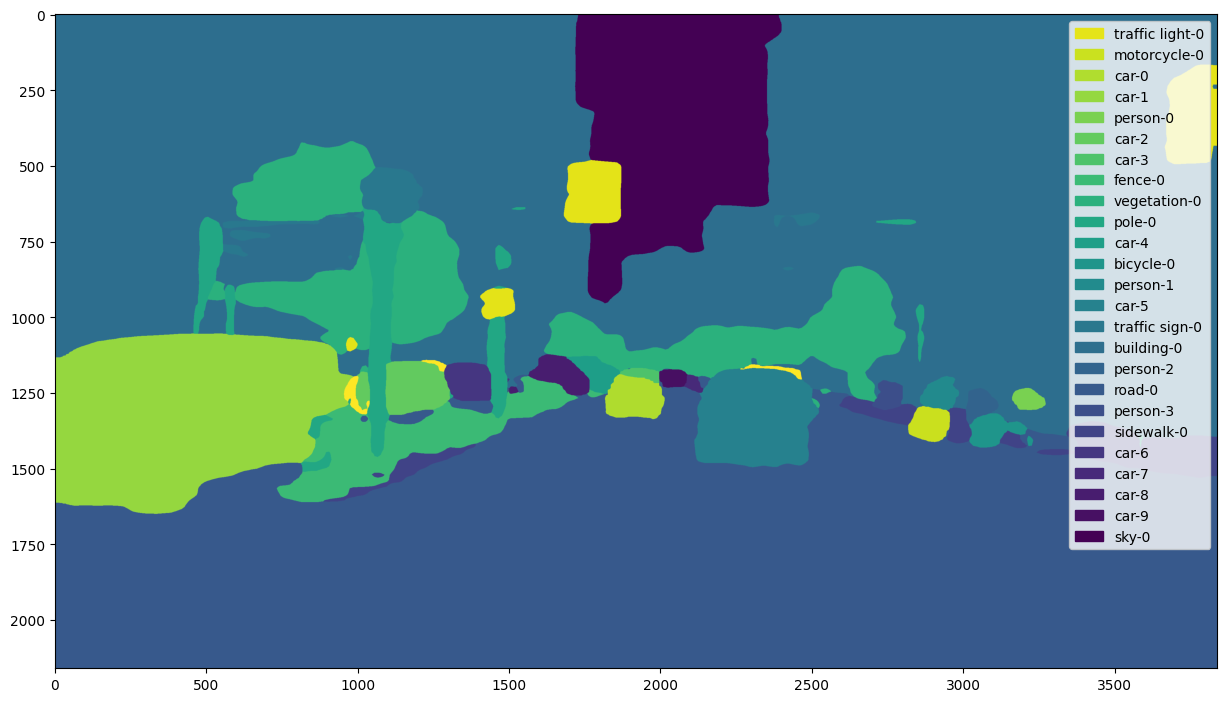

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import torch
import matplotlib.cm as cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # Get the maximum segmentation value
    max_segment_id = torch.max(segmentation).item()

    # Create a reversed color map
    viridis = cm.get_cmap('viridis', max_segment_id + 1)
    viridis_reversed = lambda x: viridis(1 - x)

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(15, 15))

    # Prepare the segmentation image with reversed colors
    segmentation_image = viridis_reversed(segmentation / max_segment_id)

    # Display the segmentation image
    ax.imshow(segmentation_image)

    instances_counter = defaultdict(int)
    handles = []

    # For each segment, draw its legend with reversed colors
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis_reversed(segment_id / max_segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    # Add legend to the plot
    ax.legend(handles=handles)

# Example usage with segmentation and segments_info
draw_panoptic_segmentation(segmentation, segments_info)


<ipython-input-9-a24a290a8a76>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


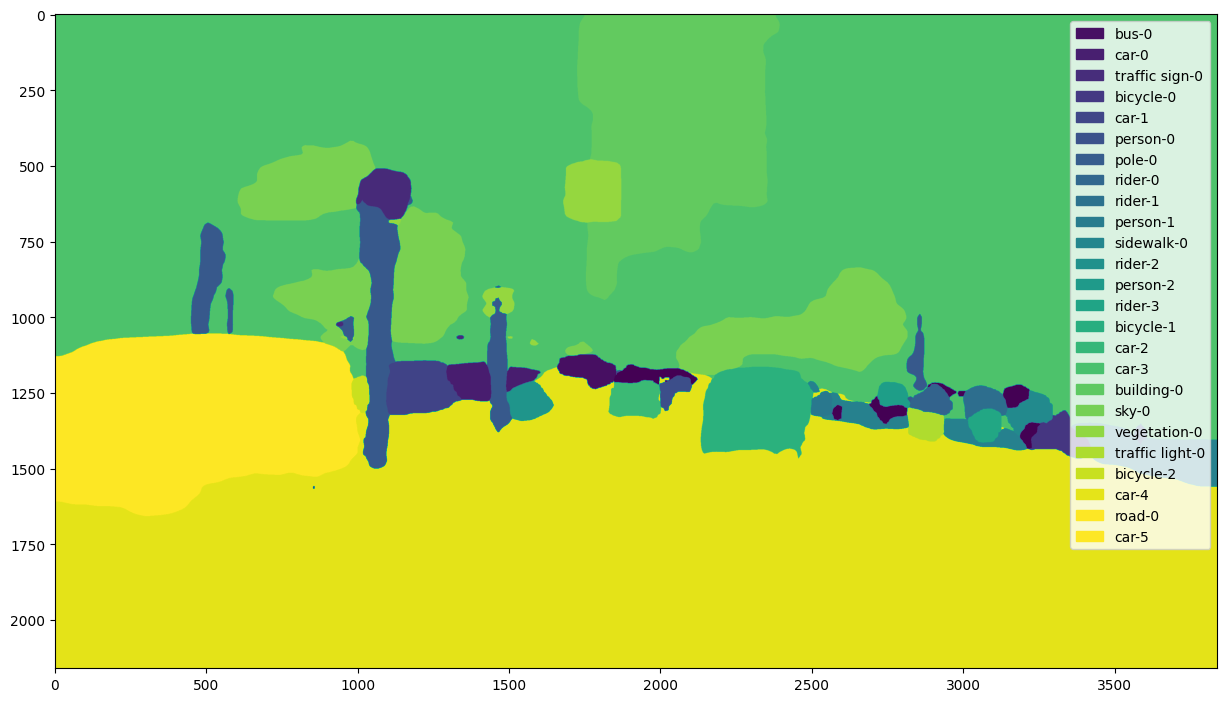

In [9]:
def draw_panoptic_segmentation(segmentation, segments_info):
    # Get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.imshow(segmentation)



    instances_counter = defaultdict(int)
    handles = []
    # For each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)

draw_panoptic_segmentation(segmentation, segments_info)


`label_ids_to_fuse` unset. No instance will be fused.


KeyboardInterrupt: 

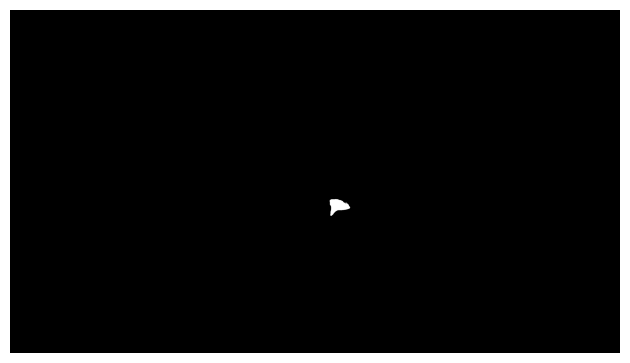

In [ ]:
for filename in result:
    if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
        # Load the image
        image_path = os.path.join(input_dir, filename)
        image = Image.open(image_path)

        # Convert grayscale image to RGB if necessary
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Process the image and perform segmentation
        inputs = processor(images=image, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process the segmentation output
        prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

        # Extract panoptic segmentation results
        segmentation = prediction['segmentation']
        segments_info = prediction['segments_info']

        # Save the segmentation with contours
        save_path = os.path.join(output_dir, filename)
        draw_and_save_segmentation_with_contours(segmentation, segments_info, save_path)